# Augmentation 적용 - 데이터 불러오기

In [10]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


### GPU 환경 확인


In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Data

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


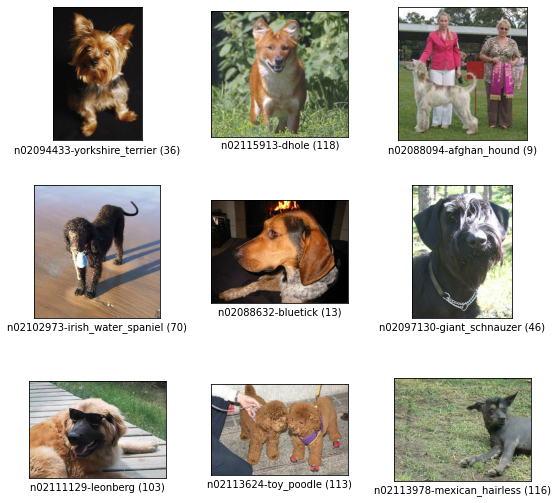

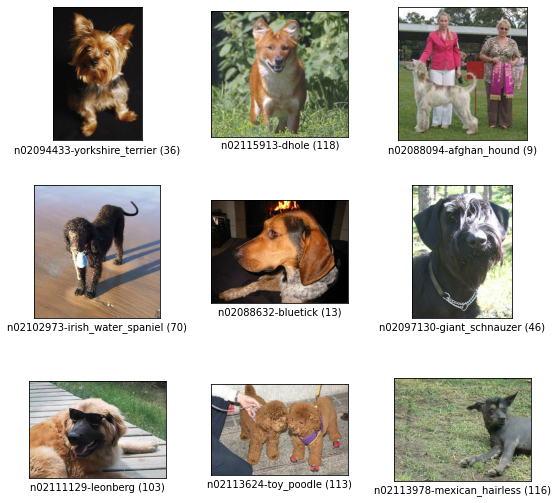

In [13]:
tfds.show_examples(ds_train, ds_info)

### Argmentation 기법
![image](https://user-images.githubusercontent.com/68802402/135563799-30d27085-d932-40b9-8cda-d44e696e6628.png)


## 데이터 전처리

In [14]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)   # 정규화시 pixel값 0~1로 변경함
    return image, label

def onehot(image,label):
    label = tf.one_hot(label, 120)
    return image, label

## No_AUG

In [15]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [26]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94773248/94765736 [==============================] - 1s 0us/step
=3


In [27]:
# Augmentation로 학습시킬 Resnet 하나 더 만들기
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [28]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


# 심화 기법 (1) Cutmix Augmentation (이미지 데이터 자르고 섞기)

## 1) 이미지 섞기


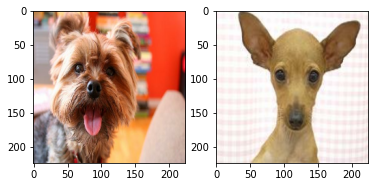

In [29]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [30]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max



In [31]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(48, shape=(), dtype=int32) tf.Tensor(168, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(96, shape=(), dtype=int32)


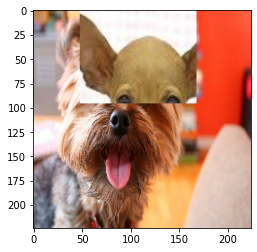

In [32]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()


## 2) 라벨 섞기


In [33]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.77040815, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [34]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# 심화 기법 (2) Mixup Augmentation

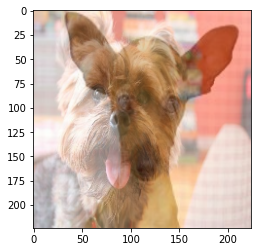

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.4663223 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.5336777 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [35]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [36]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


## Augmentation을 적용한 데이터셋 만들기

## Cutmix

In [37]:
def apply_normalize_on_dataset_cutmix(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


## Mixup

In [38]:
def apply_normalize_on_dataset_mixup(ds, is_test=False, batch_size=16, with_aug=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [39]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [40]:
# cutmix 학습시킬 Resnet 하나 더 만들기
aug_resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # include_top은 마지막 fully connected layer를 포함할지 여부이다.
                            # class 가 다를경우 False로 하고 우리가 테스트하려는 모델에 맞게 변경하면 된다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [41]:
# mixup 학습시킬 Resnet 하나 더 만들기
aug_resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # include_top은 마지막 fully connected layer를 포함할지 여부이다.
                            # class 가 다를경우 False로 하고 우리가 테스트하려는 모델에 맞게 변경하면 된다.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [93]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_mixup = apply_normalize_on_dataset_mixup(ds_train, with_aug=True,with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset_cutmix(ds_train, with_aug=True,with_cutmix=True)
ds_test_no_aug = apply_normalize_on_dataset(ds_test, is_test=True)
ds_test_aug = apply_normalize_on_dataset_cutmix(ds_test, is_test=True)



print('=3')

=3


In [100]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 333s 436ms/step - loss: 0.0822 - accuracy: 0.9910 - val_loss: 0.9293 - val_accuracy: 0.7317
Epoch 2/20
750/750 [==============================] - 328s 437ms/step - loss: 0.0562 - accuracy: 0.9954 - val_loss: 0.9308 - val_accuracy: 0.7354
Epoch 3/20
750/750 [==============================] - 328s 438ms/step - loss: 0.0285 - accuracy: 0.9976 - val_loss: 0.9162 - val_accuracy: 0.7435
Epoch 4/20
750/750 [==============================] - 329s 438ms/step - loss: 0.0133 - accuracy: 0.9998 - val_loss: 0.9954 - val_accuracy: 0.7262
Epoch 5/20
750/750 [==============================] - 329s 438ms/step - loss: 0.0101 - accuracy: 0.9999 - val_loss: 0.9443 - val_accuracy: 0.7413
Epoch 6/20
750/750 [==============================] - 328s 438ms/step - loss: 0.0083 - accuracy: 0.9999 - val_loss: 0.9522 - val_accuracy: 0.7423
Epoch 7/20
750/750 [==============================] - 328s 438ms/step - loss: 0.0076 - accuracy: 0.9998 - val_loss: 0.9565 -

In [101]:
aug_resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_aug_resnet50_mixup = aug_resnet50_mixup.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_aug,
    verbose=1,
    use_multiprocessing=True,
)
 


Epoch 1/20
750/750 [==============================] - 344s 450ms/step - loss: 2.5359 - accuracy: 0.5984 - val_loss: 1.3547 - val_accuracy: 0.6277
Epoch 2/20
750/750 [==============================] - 335s 447ms/step - loss: 2.4346 - accuracy: 0.6359 - val_loss: 1.2457 - val_accuracy: 0.6481
Epoch 3/20
750/750 [==============================] - 334s 446ms/step - loss: 2.3542 - accuracy: 0.6649 - val_loss: 1.1766 - val_accuracy: 0.6748
Epoch 4/20
750/750 [==============================] - 334s 446ms/step - loss: 2.2480 - accuracy: 0.7061 - val_loss: 1.2944 - val_accuracy: 0.6420
Epoch 5/20
750/750 [==============================] - 334s 445ms/step - loss: 2.1784 - accuracy: 0.7288 - val_loss: 1.2887 - val_accuracy: 0.6535
Epoch 6/20
750/750 [==============================] - 334s 445ms/step - loss: 2.1182 - accuracy: 0.7474 - val_loss: 1.1861 - val_accuracy: 0.6758
Epoch 7/20
750/750 [==============================] - 334s 445ms/step - loss: 2.0674 - accuracy: 0.7647 - val_loss: 1.1606 -

In [102]:
aug_resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50_cutmix = aug_resnet50_cutmix.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_aug,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 342s 447ms/step - loss: 2.5595 - accuracy: 0.5557 - val_loss: 1.3293 - val_accuracy: 0.6361
Epoch 2/20
750/750 [==============================] - 334s 445ms/step - loss: 2.4882 - accuracy: 0.5835 - val_loss: 1.5631 - val_accuracy: 0.5792
Epoch 3/20
750/750 [==============================] - 334s 446ms/step - loss: 2.3809 - accuracy: 0.6076 - val_loss: 1.3681 - val_accuracy: 0.6179
Epoch 4/20
750/750 [==============================] - 334s 446ms/step - loss: 2.3104 - accuracy: 0.6241 - val_loss: 1.1924 - val_accuracy: 0.6750
Epoch 5/20
750/750 [==============================] - 334s 445ms/step - loss: 2.1819 - accuracy: 0.6633 - val_loss: 1.1579 - val_accuracy: 0.6862
Epoch 6/20
750/750 [==============================] - 334s 445ms/step - loss: 2.1001 - accuracy: 0.6883 - val_loss: 1.1484 - val_accuracy: 0.6924
Epoch 7/20
750/750 [==============================] - 334s 446ms/step - loss: 2.0448 - accuracy: 0.7165 - val_loss: 1.3500 -

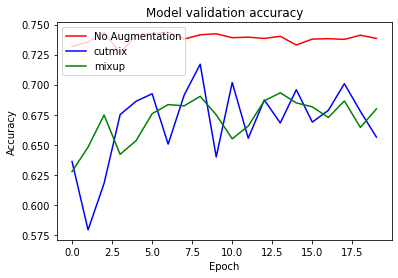

In [103]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_aug_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'cutmix','mixup'], loc='upper left')
plt.show()

* 결과가 만족스럽지 못함

## augment 수정 (Saturation 추가)

In [42]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, 0.2,0.9)
    image = tf.clip_by_value(image, 0, 1)   # 정규화시 pixel값 0~1로 변경함
    return image, label


In [43]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_mixup = apply_normalize_on_dataset_mixup(ds_train, with_aug=True,with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset_cutmix(ds_train, with_aug=True,with_cutmix=True)
ds_test_no_aug = apply_normalize_on_dataset(ds_test, is_test=True)
ds_test_aug = apply_normalize_on_dataset_cutmix(ds_test, is_test=True)



print('=3')

=3


In [44]:
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/3
750/750 [==============================] - 353s 436ms/step - loss: 3.1115 - accuracy: 0.2885 - val_loss: 2.9731 - val_accuracy: 0.2720
Epoch 2/3
750/750 [==============================] - 327s 436ms/step - loss: 0.9607 - accuracy: 0.7276 - val_loss: 1.0738 - val_accuracy: 0.6783
Epoch 3/3
750/750 [==============================] - 328s 437ms/step - loss: 0.3186 - accuracy: 0.9263 - val_loss: 0.9896 - val_accuracy: 0.7087


In [45]:
aug_resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_aug_resnet50_mixup = aug_resnet50_mixup.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_aug,
    verbose=1,
    use_multiprocessing=True,
)
 


Epoch 1/3
750/750 [==============================] - 341s 444ms/step - loss: 4.3336 - accuracy: 0.1129 - val_loss: 4.0911 - val_accuracy: 0.1265
Epoch 2/3
750/750 [==============================] - 332s 443ms/step - loss: 3.1255 - accuracy: 0.3912 - val_loss: 1.8258 - val_accuracy: 0.4967
Epoch 3/3
750/750 [==============================] - 331s 442ms/step - loss: 2.7869 - accuracy: 0.5052 - val_loss: 1.4745 - val_accuracy: 0.5863


In [46]:
aug_resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50_cutmix = aug_resnet50_cutmix.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_aug,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/3
750/750 [==============================] - 340s 444ms/step - loss: 4.4102 - accuracy: 0.1031 - val_loss: 3.0653 - val_accuracy: 0.2520
Epoch 2/3
750/750 [==============================] - 332s 442ms/step - loss: 3.2004 - accuracy: 0.3562 - val_loss: 1.4491 - val_accuracy: 0.5946
Epoch 3/3
750/750 [==============================] - 332s 442ms/step - loss: 2.8917 - accuracy: 0.4435 - val_loss: 1.4806 - val_accuracy: 0.5876


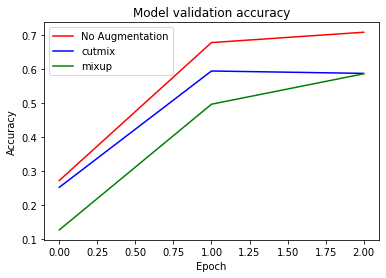

In [49]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_aug_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'cutmix','mixup'], loc='upper left')
plt.show()

|평가문항|상세기준|내용|
|:---:|:---:|:---:|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|O|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|EPOCH을 20으로 설정하여 추세를 봤지만 기존의 데이터셋보다 성능이 좋게 학습되지는 않았다.<br/> Augmetation에 Saturation기법도 추가하여 진행해봤지만 결과는 비슷하였다.<br/>이유에 대해 생각해봤는데 Augmetation은 데이터 증강을 위한 기법이기 때문에 <br/>기존의 데이터셋에 증강 셋을 추가하여 진행할 때 효과가 있는 것이라고 생각했다. <br/>하지만 그렇게 진행한다면 Train 데이터 셋의 차이가 생겨 Accuracy 비교가 무의미해질거라 판단하여 진행하지 않았다. Random하게 Augmentation 데이터 셋을 만들어 냈기 때문에 결과적으로 Accuracy가 대단히 증가하는 형태의 그래프는 볼 수 없었다. |
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|O|



